### Constant Acceleration Model in 3D space(9-dim)

\begin{align*}
& x_{n+1}=Fx_{n}+u_n,\quad x_n=[x,\dot{x},\ddot{x},y,\dot{y},\ddot{y},z,\dot{z},\ddot{z}]'
\end{align*}
where the transistion matrix is 
\begin{align*}
F=\left[\begin{matrix}F_2 & 0 & 0 \\ 0& F_2 & 0 \\ 0 & 0 & F_2\end{matrix}\right],\quad
F_2=\left[\begin{matrix}1 & T & T^2/2 \\ 0 & 1 & T\\ 0& 0 & 1\end{matrix}\right]
\end{align*}

$u_n$ is zero mean Gaussian with covariance
\begin{align*}
Q=\left[\begin{matrix}u_2 & 0 & 0 \\ 0 & u_2& 0 \\ 0 & 0 & u_2\end{matrix}\right],\quad
u_2=\left[\begin{matrix}T^4/4 & T^3/2 & T^2/2 \\ T^3/2 & T^2& T \\ T^2 & T & 1\end{matrix}\right]q_2
\end{align*}

Measurement Updata, we take the form from Li's book
\begin{align*}
z_n=h(x_n)+\sigma_0 v_n
\end{align*}
where
\begin{align*}
h=\left[
\begin{matrix}
r\\a1\\a2\\e
\end{matrix}\right]=\left[\begin{matrix}\sqrt{x^2+y^2+z^2}\\ arctan(y/x) \\arctan(y/x)\\ arctan(z/\sqrt{x^2+y^2})\end{matrix}\right]
\end{align*}

$v_n$ is zero mean Gaussian with covariance
\begin{align*}Q=diag(\sigma_r^2,\sigma_{a_1}^2,\sigma_{a_2}^2,\sigma_e^2)\end{align*}

### Parameters Setting

$T=1, q_2=1,(\sigma_r,\sigma_{a_1},\sigma_{a_2},\sigma_e)=(20,7,2,2).$ 


In [ ]:
#--------------------------------------
# library loading
#--------------------------------------
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
#%matplotlib inline
#%config InlineBackend.figure_format='svg'

#set suppress to not use scientific counting
np.set_printoptions(suppress=True) 

In [1]:
#----------------------------------------
# Initialization Math Model
#----------------------------------------
cpu_start=time.perf_counter()

# q1: variance of the process noise modeling the acceleration
T=0.1; q2=1

# qa1, qa2: variance for azimuth from sensor 1,2 resp.
# qr, qe: variance for range and elevation resp.
qr=2; qa1=0.7; qa2=0.2;qe=0.2

dimX=9; dimY=4
N=1000; n0=50; N_sample= 1000; sigma0_train=1

#Deterministic Matrix
F0=np.array([[1,T,T*T/2,0,0,0,0,0,0],
             [0,1,T,0,0,0,0,0,0],
             [0,0,1,0,0,0,0,0,0],
             [0,0,0,1,T,T*T/2,0,0,0],
             [0,0,0,0,1,T,0,0,0],
             [0,0,0,0,0,1,0,0,0],
             [0,0,0,0,0,0,1,T,T*T/2],
             [0,0,0,0,0,0,0,1,T],
             [0,0,0,0,0,0,0,0,1]])

x0=np.array([[21.68],
             [-0.3],
             [0],
             [10.8],
             [-3.9],
             [0],
             [0.4],
             [0],
             [0]])

#Covariance Matrix for random variable
#random variable u_n
Q0=np.array([[np.power(T,4)*q2/4,np.power(T,3)*q2/2,np.power(T,2)*q2/2,0,0,0,0,0,0],
             [np.power(T,3)*q2/2,np.power(T,2)*q2,T*q2,0,0,0,0,0,0],
             [np.power(T,2)*q2/2,T*q2,q2,0,0,0,0,0,0],
             [0,0,0,np.power(T,4)*q2/4,np.power(T,3)*q2/2,np.power(T,2)*q2/2,0,0,0],
             [0,0,0,np.power(T,3)*q2/2,np.power(T,2)*q2,T*q2,0,0,0],
             [0,0,0,np.power(T,2)*q2/2,T*q2,q2,0,0,0],
             [0,0,0,0,0,0,np.power(T,4)*q2/4,np.power(T,3)*q2/2,np.power(T,2)*q2/2],
             [0,0,0,0,0,0,np.power(T,3)*q2/2,np.power(T,2)*q2,T*q2],
             [0,0,0,0,0,0,np.power(T,2)*q2/2,T*q2,q2]])

#random variable v_n/w_n
R0=np.diag((qr*qr,qa1*qa1,qa2*qa2,qe*qe)) 

# generate u_n, v_n
# 1-d Gaussian: np.random.default_rng().normal(mean, std, size)
# n-d Gaussian: np.random.default_rng().multivariate_normal(mean,cov,size)
# note to reshape multivariate normal random variable to column vector.
rng=np.random.default_rng()
u=[rng.multivariate_normal(np.zeros(dimX),Q0,1).reshape(dimX,1) for i in range(N)] #!!!
v=[rng.multivariate_normal(np.zeros(dimY),R0,1).reshape(dimY,1) for i in range(N+1)] #!!!
u=np.array(u)
v=np.array(v)

#-----------------------------
# Function Definition
#-----------------------------
def f(x):
    return F0@x
def g(x):
    return np.eye(len(x))
def h(x):
    """
    input x is a 6-dim col vector, 
    return a 4-dim col vector."""
    res=np.zeros((dimY,1))
    res[0]=np.sqrt(np.square(x[0])+np.square(x[3])+np.square(x[6]))
    res[1]=np.arctan(x[3]/x[0])
    res[2]=np.arctan(x[3]/x[0])
    res[3]=np.arctan(x[6]/np.sqrt(np.square(x[0])+np.square(x[3])))
    return res
def F(x):
    """Derivative of f """
    return F0
def G(x):
    """Derivative of g """
    return np.eye(dimX)
def H(x):
    """
    Derivative of h
    input a 6-dim col vector, return 4x6 matrix."""
    res=np.zeros((dimY,dimX))
    res[0][0]=x[0]/np.sqrt(x[0]*x[0]+x[3]*x[3]+x[6]*x[6])
    res[0][3]=x[3]/np.sqrt(x[0]*x[0]+x[3]*x[3]+x[6]*x[6])
    res[0][6]=x[6]/np.sqrt(x[0]*x[0]+x[3]*x[3]+x[6]*x[6])
    
    res[1][0]=-x[3]/(x[0]*x[0]+x[3]*x[3])
    res[1][3]=x[0]/(x[0]*x[0]+x[3]*x[3])
    
    res[2][0]=-x[3]/(x[0]*x[0]+x[3]*x[3])
    res[2][3]=x[0]/(x[0]*x[0]+x[3]*x[3])
    
    res[3][0]=-x[0]*x[6]/(np.sqrt(x[0]*x[0]+x[3]*x[3])*(x[0]*x[0]+x[3]*x[3]+x[6]*x[6]))
    res[3][3]=-x[3]*x[6]/(np.sqrt(x[0]*x[0]+x[3]*x[3])*(x[0]*x[0]+x[3]*x[3]+x[6]*x[6]))
    res[3][6]=np.sqrt(x[0]*x[0]+x[3]*x[3])/(x[0]*x[0]+x[3]*x[3]+x[6]*x[6])
    
    return res

In [ ]:
#-------------------------------------
# Extended KF Monte Carlo
#-------------------------------------
def ekf_mc(F0,h,u,v,x0,sigma0_train,N):
    x_raw=np.zeros((N+1,dimX,1)); x_raw[0]=x0
    y_raw=np.zeros((N+1,dimY,1))
    y_raw[0]=h(x_raw[0])+sigma0_train*v[0]

    for k in range(N):
        x_raw[k+1]=F0@x_raw[k]+u[k]  #!!! here is u[k]
        y_raw[k+1]=h(x_raw[k+1])+sigma0_train*v[k+1]  #!!! add sigma0_train
        
    return x_raw,y_raw

#-------------------------------------
# Extended Kalman Filter Algorithm
#-------------------------------------

def extended_kf(f,g,h,F,G,H,Q0,R0,x0,y_raw,N):
    """
    f,g,h,F,G,H are all functions.
    Q0: covariance matrix of u_n
    R0: covariance matrix of v_n """
    x_hat=np.zeros((N+1,dimX,1)); x_hat[0]=x0
    R=np.zeros((N+1,dimX,dimX)); R[0]=np.eye(dimX) #!!!!!!
    x_bar=np.zeros((N+1,dimX,1)) 
    x_bar[0]=x_hat[0]+R[0]@H(x_hat[0]).T@np.linalg.inv(H(x_hat[0])@R[0]@H(x_hat[0]).T+R0)@(y_raw[0]-h(x_hat[0]))
    
    for k in range(N):   
        x_hat[k+1]=f(x_bar[k])
        inv_pre=np.linalg.inv(H(x_hat[k])@R[k]@H(x_hat[k]).T+R0)
        R[k+1]=F(x_bar[k])@(R[k]-R[k]@H(x_hat[k]).T@inv_pre@H(x_hat[k])@R[k])@F(x_bar[k]).T+G(x_bar[k])@Q0@G(x_bar[k]).T
        inv_pos=np.linalg.inv(H(x_hat[k+1])@R[k+1]@H(x_hat[k+1]).T+R0)
        x_bar[k+1]=x_hat[k+1]+R[k+1]@H(x_hat[k+1]).T@inv_pos@(y_raw[k+1]-h(x_hat[k+1]))
        
    return x_hat,x_bar


#-----------------------------------------------------------------------------------------
# Generating tons of samples
#-----------------------------------------------------------------------------------------

def sample_generator(Q0,R0,sigma0_train):
    
    datas=np.zeros(((N-n0+2)*N_sample,n0,dimY)) #for each sample path, we have N-n0+2 data
    labels=np.zeros(((N-n0+2)*N_sample,dimX))
    
    x_bars=np.zeros(((N-n0+2)*N_sample,dimX)) #store Kalman filtering estimation value.
    x_hats=np.zeros(((N-n0+2)*N_sample,dimX))
    
    x_raws=np.zeros((N_sample, N+1, dimX, 1))
    y_raws=np.zeros((N_sample, N+1, dimY, 1))
    
    for i in range(N_sample):
        data=np.zeros((N-n0+2,n0,dimY)) #store data for each sample
        label=np.zeros((N-n0+2,dimX))
        # call ekf_mc function to generate sample
        x_raw,y_raw=ekf_mc(F0,h,u,v,x0,sigma0_train)
        x_raws[i]=x_raw; y_raws[i]=y_raw
        
        # call extended_kf function to compute estimation
        # make sure here y_raw to be column vector
        x_hat, x_bar=extended_kf(f,g,h,F,G,H,Q0,R0,x0,y_raw,N)
        
        # convert x_raw... into row vector
        x_raw=x_raw.reshape(N+1,dimX) 
        y_raw=y_raw.reshape(N+1,dimY)
        x_hat=x_hat.reshape(N+1,dimX)
        x_bar=x_bar.reshape(N+1,dimX)
        # make data and label for each sample
        for k in range(N-n0+2):
            data[k]=y_raw[k:k+n0]
            label[k]=x_raw[k+n0-1]
            
        # put data and label into datas and labels with i representing sample number
        datas[i*(N-n0+2):(i+1)*(N-n0+2)]=data
        labels[i*(N-n0+2):(i+1)*(N-n0+2)]=label
        x_hats[i*(N-n0+2):(i+1)*(N-n0+2)]=x_hat[n0-1:]
        x_bars[i*(N-n0+2):(i+1)*(N-n0+2)]=x_bar[n0-1:]
    
    return datas,labels,x_hats,x_bars,x_raws,y_raws

In [ ]:
# call sample_generator function to generate sample
#datas, labels, x_hats,x_bars,x_raws, y_raws=sample_generator()

Epoch 1/10
47600/47600 [==============================] - 19s 396us/step - loss: 0.2242 - mean_squared_error: 0.2242
Epoch 2/10
47600/47600 [==============================] - 19s 397us/step - loss: 0.0961 - mean_squared_error: 0.0961
Epoch 3/10
47600/47600 [==============================] - 19s 389us/step - loss: 0.0837 - mean_squared_error: 0.0837
Epoch 4/10
47600/47600 [==============================] - 19s 395us/step - loss: 0.0714 - mean_squared_error: 0.0714
Epoch 5/10
47600/47600 [==============================] - 19s 392us/step - loss: 0.0617 - mean_squared_error: 0.0617
Epoch 6/10
47600/47600 [==============================] - 19s 392us/step - loss: 0.0570 - mean_squared_error: 0.0570
Epoch 7/10
47600/47600 [==============================] - 19s 390us/step - loss: 0.0545 - mean_squared_error: 0.0545
Epoch 8/10
47600/47600 [==============================] - 19s 390us/step - loss: 0.0528 - mean_squared_error: 0.0528
Epoch 9/10
47600/47600 [==============================] - 19s 38

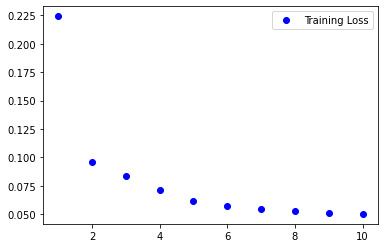

In [2]:
#--------------------------
# Deep Filtering Function
#--------------------------

def deep_filtering(datas,labels,x_hats,x_bars,x_raws,y_raws):
    
    # Data preprocessing procedure
    datas=datas.reshape(((N-n0+2)*N_sample,dimY*n0))
    # convert numpy array into pandas dataframe
    datas=pd.DataFrame(datas)
    labels=pd.DataFrame(labels)
    x_hats=pd.DataFrame(x_hats)
    x_bars=pd.DataFrame(x_bars)
    
    # Data Normalization/Scaling

    from sklearn.model_selection import train_test_split
    seed=3
    np.random.seed(seed)
    training_data, test_data, training_label, test_label=train_test_split(datas,labels, test_size=0.2, random_state=seed)

    # Input normalization
    data_mean=training_data.mean(axis=0)
    data_std=training_data.std(axis=0)
    training_data=(training_data-data_mean)/data_std
    test_data=(test_data-data_mean)/data_std

    # Output normalization
    label_mean=training_label.mean(axis=0)
    label_std=training_label.std(axis=0)
    training_label=(training_label-label_mean)/label_std
    test_label=(test_label-label_mean)/label_std

    #-------------------------------
    # DNN Model building
    #-------------------------------

    from keras import models
    from keras import layers
    from keras import optimizers

    def build_model():
        model=models.Sequential()
        model.add(layers.Dense(5,activation='relu',input_shape=(dimY*n0,)))
        model.add(layers.Dense(5,activation='relu'))
        model.add(layers.Dense(5,activation='relu'))
        model.add(layers.Dense(5,activation='relu'))
        model.add(layers.Dense(5,activation='relu'))
        model.add(layers.Dense(dimX))

        model.compile(optimizer=optimizers.SGD(lr=0.001), 
                      loss='mean_squared_error', 
                      metrics=[tf.keras.metrics.MeanSquaredError()])
        return model

    model=build_model()
    mymodel=model.fit(training_data,training_label, epochs=10, batch_size=16)

    #-------------------------------
    # Evaluation Performance
    #-------------------------------

    from sklearn.metrics import mean_squared_error

    test_mse_score, test_mae_score=model.evaluate(test_data,test_label)

    index=test_label.index.tolist()
    kf_mse_err=mean_squared_error(x_bars.iloc[index],labels.iloc[index])

    cpu_end=time.perf_counter()

    #print("The mse of deep filtering is {:.3%}".format(test_mse_score))
    #print("The mse of Kalman Filtering is {:.3%}".format(kf_mse_err))
    #print("The CPU consuming time is {:.5}".format(cpu_end-cpu_start))


    #history_dict=mymodel.history
    #history_dict.keys()

    #loss_value=history_dict['loss']
    #val_loss_value=history_dict['val_loss']
    #epochs=range(1,10+1)
    #import matplotlib.pyplot as plt
    #plt.plot(epochs, loss_value, 'bo',label='Training Loss')
    #plt.plot(epochs, val_loss_value,'b',label='Validation Loss')
    #plt.legend()
    #plt.show()

<Figure size 24000x18000 with 0 Axes>

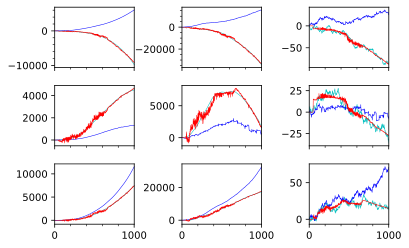

In [3]:
#-------------------------------------------------------------
# plot on new data
#-------------------------------------------------------------
def graph_plot(N):
    
    x_new, y_new=ekf_mc(F0,h,u,v,x0,sigma0_train,N)
    x_hat_new, x_bar_new=extended_kf(f,g,h,F,G,H,Q0,R0,x0,y_new,N)
    
    y_new=y_new.reshape(N+1,dimY)
    data_new=np.zeros((N-n0+2,n0,dimY))
    for k in range(N-n0+2):
        data_new[k]=y_new[k:k+n0]
    # convert data to be consistent with deep learning.
    data_new=data_new.reshape(N-n0+2,n0*dimY)
    data_new=pd.DataFrame(data_new)

    # Before predict, normalize data with training information.
    data_new=(data_new-data_mean)/data_std
    df_pred=model.predict(data_new)
    for i in range(N-n0+2):
        # convect df results back to original scale.
        df_pred[i,:]=df_pred[i,:]*label_std+label_mean

    df_new=[x0 for k in range(n0-1)]
    df_new=np.array(df_new)
    df_new=df_new.reshape(n0-1,dimX)
    df_new=np.vstack((df_new,df_pred))
    
    #--------------------------------

    plt.figure(dpi = 600,figsize=[40,30])
    axis=np.linspace(0,N+1,N+1)
    fig,ax=plt.subplots(3,3,sharex=True)
    plt.xlim((0,1))
    ax[0][0].plot(axis, x_new[:,0]/1000,'c',axis,x_bar_new[:,0]/1000,'b',axis,df_new[:,0]/1000,'r',linewidth=0.5)
    ax[0][0].set_xlim((0,N+1))
    ax[0][0].minorticks_on()
    ax[0][1].plot(axis, x_new[:,1],'c',axis,x_bar_new[:,1],'b',axis,df_new[:,1],'r',linewidth=0.5)
    ax[0][1].minorticks_on()
    ax[0][2].plot(axis, x_new[:,2],'c',axis,x_bar_new[:,2],'b',axis,df_new[:,2],'r',linewidth=0.5)
    #y 
    ax[1][0].plot(axis, x_new[:,3]/1000,'c',axis,x_bar_new[:,3]/1000,'b',axis,df_new[:,3]/1000,'r',linewidth=0.5)
    ax[1][1].plot(axis, x_new[:,4],'c',axis,x_bar_new[:,4],'b',axis,df_new[:,4],'r',linewidth=0.5)
    ax[1][2].plot(axis, x_new[:,5],'c',axis,x_bar_new[:,5],'b',axis,df_new[:,5],'r',linewidth=0.5)
    # z
    ax[2][0].plot(axis, x_new[:,6]/1000,'c',axis,x_bar_new[:,6]/1000,'b',axis,df_new[:,6]/1000,'r',linewidth=0.5)
    ax[2][1].plot(axis, x_new[:,7],'c',axis,x_bar_new[:,7],'b',axis,df_new[:,7],'r',linewidth=0.5)
    ax[2][2].plot(axis, x_new[:,8],'c',axis,x_bar_new[:,8],'b',axis,df_new[:,8],'r',linewidth=0.5)


    fig.subplots_adjust(wspace=0.6, hspace=0.3)
    plt.savefig('6dim-plot.pdf')
    plt.show()

In [ ]:
#-------------------------------
# Data backup or Store
#--------------------------------
# store Monte Carlo sample data
#np.save(file='datas/df-CV2D-m2-x_raws.npy',arr=x_raws)
#np.save(file='datas/df-CV2D-m2-y_raws.npy',arr=y_raws)
# Store training and test data
#store=pd.HDFStore('datas/df-CV2D-m2_datas.h5')
#store['datas']=datas
#store['labels']=labels
#store['x_hats']=x_hats
#store['x_bars']=x_bars
#store['training_data']=training_data
#store['training_label']=training_label
#store['data_mean']=data_mean
#store['data_std']=data_std
#store['test_data']=test_data
#store['test_label']=test_label
#store['label_mean']=label_mean
#store['label_std']=label_std
# store DNN model
#model.save('datas/df-CV2D-m2-model.h5',overwrite=True)
# store path data
#np.save(file='datas/df-CV2D-m2-x_new',arr=x_new)
#np.save(file='datas/df-CV2D-m2-y_new',arr=y_new)
#np.save(file='datas/df-CV2D-m2-x_bar_new',arr=x_bar_new)
#np.save(file='datas/df-CV2D-m2-df_new',arr=df_new)

### Error Dependence Analysis

\begin{align*}
NM:
\begin{cases}
x_{n+1}=Fx_{n}+u_n,\quad x_n=[x,\dot{x},\ddot{x},y,\dot{y},\ddot{y},z,\dot{z},\ddot{z}]' \\
z_n=h(x_n)+\sigma_0^{NM} v_n
\end{cases}
\end{align*}

\begin{align*}
AM:
\begin{cases}
x_{n+1}=Fx_{n}+u_n,\quad x_n=[x,\dot{x},\ddot{x},y,\dot{y},\ddot{y},z,\dot{z},\ddot{z}]' \\
z_n=h(x_n)+\sigma_0^{AM} v_n
\end{cases}
\end{align*}

---
1. Error Dependence on $\sigma_0^{NM}$, fix $\sigma_0^{AM}=0.5$ and vary $\sigma_0^{NM}=0.1, 0.5, 1.0, 1.5, 2.0, 2.5$
2. Error Dependence on $\sigma_0^{AM}$, fix $\sigma_0^{NM}=0.5$ and vary $\sigma_0^{AM}=0.1, 0.5, 1.0, 1.5, 2.0, 2.5$

In [ ]:
#----------------------------
# Robustness Analysis for NM 
#----------------------------

def robust_analysis_NM():
    sigma0_AM=0.5;  sigma0_NM=np.array([0.1, 0.5, 1.0, 1.5, 2.0, 2.5])
    
    # For kalman Filter, we use NM model with recursive formula and Riccati equation.
    # But when applying KF procedure, use observation from AM that is y_n is from AM model.
    
    R0_NM=np.zeros((len(sigma0_NM),dimY,dimY))
    
    for i in range(len(sigma0_NM)):
        
        R0_NM[i]=sigma0_NM[i]*sigma0_NM[i]*R0
        # first train a DF model with NM noise for use
        datas, labels, x_hats, x_bars, x_raws, y_raws=sample_generator(Q0,R0_NM[i],sigma0_NM[i]) #!!!
        model, data_mean, data_std, label_mean, label_std=deep_filtering(datas,labels,x_hats,x_bars,x_raws,y_raws)
        
        # second generating samples with AM model noise
        x_raw_AM, y_raw_AM=ekf_mc(F0,h,u,v,x0,sigma0_AM,N)
      
        # Riccati equation with NM, observation with AM
        x_hat, x_bar=extended_kf(f,g,h,F,G,H,Q0,R0_NM[i],x0,y_raw_AM,N)
        
        x_raw_AM=x_raw_AM.reshape(N+1,dimX)
        y_raw_AM=y_raw_AM.reshape(N+1,dimY)
        x_bar=x_bar.reshape(N+1,dimX)
        data_new_AM=np.zeros((N-n0+2,n0,dimY))
        
        for k in range(N-n0+2):
            data_new_AM[k]=y_raw_AM[k:k+n0]
            
        data_new_AM=data_new_AM.reshape(N-n0+2,n0*dimY)
        data_new_AM=pd.DataFrame(data_new_AM)
        # input normalization
        data_new_AM=(data_new_AM-data_mean)/data_std # data_mean and data_std come from NM noise.
        df_pred=model.predict(data_new_AM)
        for k in range(N-n0+2):
            # convect df results back to original scale.
            df_pred[k,:]=df_pred[k,:]*label_std+label_mean
            
        from sklearn.metrics import mean_squared_error
        # Deep Filtering Error
        df_mse_err=mean_squared_error(x_raw_AM[n0-1:],df_pred)
        kf_mse_err=mean_squared_error(x_raw_AM[n0-1:],x_bar[n0-1:])
        temp=sigma0_NM[i]
        
        print("For fixed sigma0_AM and sigma0_NM %.2f, the mse errs of df and kf are: %.2f,%.2f"%(temp,df_mse_err, kf_mse_err))

#----------------------------
# Robustness Analysis for AM
#----------------------------

def robust_analysis_AM():
    sigma0_AM=np.array([0.1, 0.5, 1.0, 1.5, 2.0, 2.5]); sigma0_NM=0.5  
    
    # For kalman Filter, we use NM model with recursive formula and Riccati equation.
    # But when applying KF procedure, use observation from AM that is y_n is from AM model.
    
    R0_NM=sigma0_NM*sigma0_NM*R0
    R0_AM=np.zeros((len(sigma0_AM),dimY,dimY))
    
    for i in range(len(sigma0_AM)):
        
        R0_AM[i]=sigma0_AM[i]*sigma0_AM[i]*R0
        # first train a DF model with NM noise for use
        datas, labels, x_hats, x_bars, x_raws, y_raws=sample_generator(Q0,R0_NM,sigma0_NM) #!!!
        model, data_mean, data_std, label_mean, label_std=deep_filtering(datas,labels,x_hats,x_bars,x_raws,y_raws)
        
        # second generating samples with AM model noise
        x_raw_AM, y_raw_AM=ekf_mc(F0,h,u,v,x0,sigma0_AM[i],N)
        
        # Riccati equation with NM, observation with AM
        x_hat, x_bar=extended_kf(f,g,h,F,G,H,Q0,R0_NM,x0,y_raw_AM,N)
        
        x_raw_AM=x_raw_AM.reshape(N+1,dimX)
        y_raw_AM=y_raw_AM.reshape(N+1,dimY)
        x_bar=x_bar.reshape(N+1,dimX)
        data_new_AM=np.zeros((N-n0+2,n0,dimY))
        
        for k in range(N-n0+2):
            data_new_AM[k]=y_raw_AM[k:k+n0]
            
        data_new_AM=data_new_AM.reshape(N-n0+2,n0*dimY)
        data_new_AM=pd.DataFrame(data_new_AM)
        # input normalization
        data_new_AM=(data_new_AM-data_mean)/data_std # data_mean and data_std come from NM noise.
        df_pred=model.predict(data_new_AM)
        for k in range(N-n0+2):
            # convect df results back to original scale.
            df_pred[k,:]=df_pred[k,:]*label_std+label_mean
        from sklearn.metrics import mean_squared_error
        
        # Deep Filtering Error
        df_mse_err=mean_squared_error(x_raw_AM[n0-1:],df_pred)
        kf_mse_err=mean_squared_error(x_raw_AM[n0-1:],x_bar[n0-1:])
        print("For fixed sigma0_NM and sigma0_AM %.2f, the mse errs of df and kf are: %.2f, %.2f"%(sigma0_AM[i],df_mse_err, kf_mse_err))  

In [1]:
robust_analysis_NM()
robust_analysis_AM()

NameError: name 'robust_analysis_NM' is not defined